In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
import torch.nn as nn
import torch
from torch import nn
from sklearn.model_selection import KFold
from itertools import product
from monk_helpers import CV,SEED
import matplotlib.pyplot as plt
import multiprocess
from sklearn.metrics import accuracy_score, classification_report



Create reproducible results

In [216]:
torch.manual_seed(SEED)
np.random.seed(SEED)
gen = torch.Generator().manual_seed(SEED)


In [217]:
num_processes = multiprocess.cpu_count()

print("Number of cpu : ", num_processes)
pool = multiprocess.Pool(processes=num_processes - 4)

Number of cpu :  8


In [218]:
# Datasets Path
TR_PATH_1 = "./monks/datasets/monks-1.train"
TS_PATH_1 = "./monks/datasets/monks-1.test"
# Datasets Path
TR_PATH_2 = "./monks/datasets/monks-2.train"
TS_PATH_2 = "./monks/datasets/monks-2.test"
# Datasets Path
TR_PATH_3 = "./monks/datasets/monks-3.train"
TS_PATH_3 = "./monks/datasets/monks-3.test"

In [219]:

def plot_graph(train_losses,validation_losses,epochs,title):
    num_epochs = list(range(1, epochs + 2))  
    # Plotting
    plt.plot(num_epochs, train_losses, label='Training Loss')
    plt.plot(num_epochs, validation_losses, label=title+'Loss')

    plt.title('Training and'+title+'Losses Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [220]:
class Net(nn.Module):

  def __init__(self, input_size, units, output_size,):
    super().__init__()
    self.units = units

    self.l1 = nn.Linear(input_size, units)
    self.l2 = nn.Linear(units, output_size)

  def forward(self, x):
    out = torch.tanh(self.l1(x))
    out = torch.sigmoid(self.l2(out))
    return out


def reset_weights(net):
  for param in net.parameters():
    torch.nn.init.uniform_(param, a=-0.7, b=0.7)

In [221]:
def read_ds(path):
  """
  parse CSV data set and
  returns a tuple (input, target)
  """
  names = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
  data = pd.read_csv(path, dtype=object, delim_whitespace=True, header=None, skipinitialspace=True, names=names)

  X = data.drop(['class','id'], axis=1)
  X = pd.get_dummies(X).astype(float).to_numpy()
  y = data.drop(['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id'], axis=1)
  y = y.astype(float).to_numpy()


  return np.concatenate((y, X), axis=1)

In [222]:
class ToleranceStopper:
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_training_loss = np.inf

  def tol_stop(self, training_loss):
    if training_loss > (self.min_training_loss - self.min_delta):
      self.counter +=1
      if self.counter >= self.patience:
        return True
    else: 
      self.counter = 0
    if training_loss < self.min_training_loss:
      self.min_training_loss = training_loss
    
    return False

In [223]:
def fit_model(input_size,hidden_size,output_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,testloader):
    # Init the neural network
    network = Net(input_size, hidden_size, output_size)
    network.apply(reset_weights) #reset weights with random initialization
    # Use the GPU, if possible
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
      if torch.cuda.device_count() > 1:
        network = nn.DataParallel(network)
    network.to(device)

    # Initialize optimizer
    if (opt.__name__ == "RMSprop") or (opt.__name__ == "SGD"):
      optimizer = opt(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
      optimizer = opt(network.parameters(), lr=learning_rate, weight_decay=weight_decay)

    
    train_losses = []
    test_losses = []

    tolerance_stopper = ToleranceStopper(patience=20, min_delta=1e-4)

    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss and accuracy value for train
      train_loss = 0.0
      epoch_train_accuracy = []


      # Set current loss and accuracy value for test
      test_loss = 0.0
      epoch_test_accuracy = []

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, 1:].to(torch.float32).to(device)
        targets = data[:, [0]].to(torch.float32).to(device)

        # Zero the gradients
        optimizer.zero_grad() 

        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)
      # Print loss values
      epoch_train_loss = train_loss / len(trainloader.sampler)    
      train_losses.append(epoch_train_loss)
      # Update accuracy
      for output, target in zip(outputs, targets):
        output = 0 if output.item() < 0.5 else 1
        if output == target.item():
          epoch_train_accuracy.append(1)
        else:
          epoch_train_accuracy.append(0)
      
      with torch.no_grad():
        # Iterate over the testing data and generate predictions
        for i, data in enumerate(testloader, 0):

          inputs = data[:, 1:].to(torch.float32).to(device)
          targets = data[:, [0]].to(torch.float32).to(device)
        
          outputs = network(inputs)

          loss = loss_function(outputs, targets)
          
          test_loss += loss.item() * inputs.size(0)

        epoch_test_loss = test_loss / len(testloader.sampler)    
        test_losses.append(epoch_test_loss)

        # Update accuracy
        for output, target in zip(outputs, targets):
          output = 0 if output.item() < 0.5 else 1
          if output == target.item():
            epoch_test_accuracy.append(1)
          else:
            epoch_test_accuracy.append(0)
        print(epoch_test_loss)
        if tolerance_stopper.tol_stop(epoch_test_loss):
          print("Early stopping: ",epoch)
          break

    plot_graph(train_losses,test_losses,epoch,"test")
    return network


In [224]:
def k_fold_model(input_size,hidden_size,output_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,validationloader,l1_lambda=0):
    
    # Init the neural network
    network = Net(input_size, hidden_size, output_size)
    network.apply(reset_weights) #reset weights with random initialization
    
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    # Initialize optimizer
    '''if (opt.__name__ == "RMSprop") or (opt.__name__ == "SGD"):
      optimizer = opt(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
      optimizer = opt(network.parameters(), lr=learning_rate, weight_decay=weight_decay)'''

    tolerance_stopper = ToleranceStopper(patience=20, min_delta=1e-4)
    train_losses = []
    validaition_losses = []
    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      # Print epoch
      #print(f'Starting epoch {epoch+1}')

      # Set current loss value
      train_loss = 0.0
      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, 1:].to(torch.float32)
        targets = data[:, [0]].to(torch.float32)

        # Zero the gradients
        optimizer.zero_grad() 
        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        if(l1_lambda > 0):
          l1_norm = sum(torch.linalg.norm(p, 1) for p in network.parameters())
          loss = loss + l1_lambda * l1_norm
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)

        #print("loss per item", loss.item())
        #print("inputs size",inputs.size(0))

        # Print loss values
      #print("train loaders length",len(trainloader.sampler.indices))

      epoch_train_loss = train_loss / len(trainloader.sampler)    
      train_losses.append(epoch_train_loss) 
      #print(f'Training loss: {avg_train_loss}')
      # Print about testing
      #print('Starting validation')

      # Evaluationfor this fold
      valid_loss = 0.0 
      with torch.no_grad():
        # Iterate over the validation data and generate predictions
        for i, data in enumerate(validationloader, 0):

          # Get inputs
          inputs = data[:, 1:].to(torch.float32)
          targets = data[:, [0]].to(torch.float32)
          
          # Generate outputs
          outputs = network(inputs)

          loss = loss_function(outputs, targets)

          # Calculate loss
          valid_loss += loss.item() * inputs.size(0)
          #print("loss per item", loss.item())
          #print("inputs size",inputs.size(0))
        
        #print("validation loaders length",len(validationloader.sampler.indices))

        avg_valid_loss = valid_loss / len(validationloader.sampler) #used to find the best parameters of the model
        validaition_losses.append(avg_valid_loss)
        # Early stopping
        if tolerance_stopper.tol_stop(avg_valid_loss):
          print("Early stopping:", epoch)
          break
        # Print validation results
        #print(f'Validation loss: {avg_valid_loss:.4f}')


    #plot_graph(train_losses,validaition_losses,epoch,"validation")
    return avg_valid_loss


In [225]:
def execute_folds(kfold,dataset,batch_size,input_size, hidden_size, output_size, learning_rate, epochs,
    loss_function, momentum, opt, weight_decay,l1_lambda):
    gen = torch.Generator().manual_seed(SEED)
    
    validation_avg_loss_fold = 0
    num_iterations = 0
    current_config = {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'output_size': output_size,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'momentum': momentum,
        'opt': opt,
        'weight_decay': weight_decay,
        "batch_size":batch_size,
        "loss_function":loss_function
    }
 
    for fold, (train_ids, val_ids) in enumerate(kfold.split(np.zeros(len(dataset)),dataset[:, 0])):

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids, gen) 
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids, gen) 
        # Print
        #print(f'FOLD {fold}')

        #print('--------------------------------')
        # Define data loaders for training and testing data in this fold
        
        trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=batch_size, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=batch_size, sampler=validation_subsampler)    
        

        validation_loss = k_fold_model(learning_rate=learning_rate,epochs=epochs,hidden_size=hidden_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                    ,opt=opt,output_size=output_size,trainloader=trainloader,weight_decay=weight_decay,validationloader=validationloader,l1_lambda = l1_lambda)   
        validation_avg_loss_fold  += validation_loss
        num_iterations += 1


    #validation average over all folds
    validation_avg_loss_fold /= num_iterations
    
    return (validation_avg_loss_fold, current_config)

function that executes the folds for each combination of parameters

In [226]:
def dogridsearch(dataset_train_part,params_grid,output_size,input_size):
    
    dataset = dataset_train_part
    # Set fixed random number seed
    loss_function = nn.MSELoss()

    # Define the K-fold Cross Validator
    kfold = CV 
    
    # K-fold Cross Validation model evaluation
    best_params = None

    actual_it = 0
    total_iterations = len(params_grid["epochs"]) * len(params_grid["optimizer"]) * len(params_grid["hidden_size"]) * len(params_grid["learning_rate"]) * len(params_grid["batch_size"]) * len(params_grid["weight_decay"]) * len(params_grid["momentum"]) * len(params_grid["l1_lambda"])


    configurations = []

    for epochs, opt, hidden_size, learning_rate, batch_size, weight_decay, momentum,l1_lambda in product(params_grid["epochs"],params_grid["optimizer"], params_grid["hidden_size"], params_grid["learning_rate"], params_grid["batch_size"], params_grid["weight_decay"], params_grid["momentum"],params_grid["l1_lambda"]):
        #print the actual percentage of the grid search
        print(f'Actual iter {(actual_it/total_iterations)*100}%')

        (validation_avg_loss_fold, current_config) = execute_folds(kfold=kfold,dataset=dataset,learning_rate=learning_rate,epochs=epochs,hidden_size=hidden_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                        ,opt=opt,output_size=output_size,weight_decay=weight_decay,batch_size=batch_size,l1_lambda=l1_lambda)


        configurations.append((validation_avg_loss_fold, current_config))
        
        actual_it += 1


    #best 
    for conf_val in configurations:
        if best_params is None or conf_val[0] < best_params[0]:
                current_config = conf_val[1]
                best_params = (conf_val[0]
                ,current_config['learning_rate'], current_config['epochs'],current_config["loss_function"],current_config['hidden_size'],current_config['momentum'],current_config['opt'],
                current_config['weight_decay'],
                current_config['batch_size'])

    return best_params

test the created model and plot training/test error

In [227]:
def train_test_model(dataset_train_part,dataset_test_part,best_params):
    train_subsampler = torch.utils.data.SubsetRandomSampler(range(len(dataset_train_part)), gen)

    trainloader = torch.utils.data.DataLoader(
                        dataset_train_part, 
                        batch_size=best_params[8], sampler=train_subsampler)

    test_subsampler =  torch.utils.data.SubsetRandomSampler(range(len(dataset_test_part)), gen)
    testloader = torch.utils.data.DataLoader(
                        dataset_test_part, 
                        batch_size=best_params[8], sampler=test_subsampler)

    best_net = fit_model(learning_rate=best_params[1],epochs=best_params[2],hidden_size=best_params[4],input_size=17,loss_function=best_params[3],
                        momentum=best_params[5],opt=best_params[6],output_size=1,trainloader=trainloader,weight_decay=best_params[7],testloader=testloader)   
    return best_net

In [228]:
input_size = 17  
output_size = 1
params_grid_general = {
    "hidden_size": [3, 4, 5],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0,0.001,0.01],
    "momentum": [0,0.1,0.4,0.7,0.8],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
    "l1_lambda":[0]

}


params_grid = {
    "hidden_size": [4],
    "learning_rate": [0.8],
    "batch_size": [4],
    "weight_decay": [0],
    "momentum": [0.5],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
    "l1_lambda":[0]
}
    

dataset_train_part = read_ds(TR_PATH_1)
dataset_test_part = read_ds(TS_PATH_1)

dataset = dataset_train_part

best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size)
        




Actual iter 0.0%


Early stopping: 139
Early stopping: 75
Early stopping: 49
Early stopping: 49
Early stopping: 49


monk 1:
Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.0022038360655424185, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)

In [229]:
#Best parameters found
print(f"Best hidden size: {best_params[4]} \nBest learning rate: {best_params[1]} \nBest batch size: {best_params[8]} \nBest weight decay: {best_params[7]} \nBest momentum: {best_params[5]}")

print(best_params)

Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.028025031715800196, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)


Starting epoch 1
0.18771562397617986
Starting epoch 2
0.17882693631367552
Starting epoch 3
0.20418169468434322
Starting epoch 4
0.18158202733913506
Starting epoch 5
0.16706302675797982
Starting epoch 6
0.16068615602260386
Starting epoch 7
0.12906271182173104
Starting epoch 8
0.11727332043530489
Starting epoch 9
0.08385523322202196
Starting epoch 10
0.03571051161917341
Starting epoch 11
0.02738522645544166
Starting epoch 12
0.013674696597667612
Starting epoch 13
0.008411803061823809
Starting epoch 14
0.007331474871736848
Starting epoch 15
0.005803422581973589
Starting epoch 16
0.005342960880996004
Starting epoch 17
0.004527187831559719
Starting epoch 18
0.00418194073211419
Starting epoch 19
0.0036681532866269764
Starting epoch 20
0.0031920284953365036
Starting epoch 21
0.0030075006593337835
Starting epoch 22
0.002812411798338922
Starting epoch 23
0.0024891168494899896
Starting epoch 24
0.0024228821484602696
Starting epoch 25
0.0022568494155334688
Starting epoch 26
0.0021155802053356267


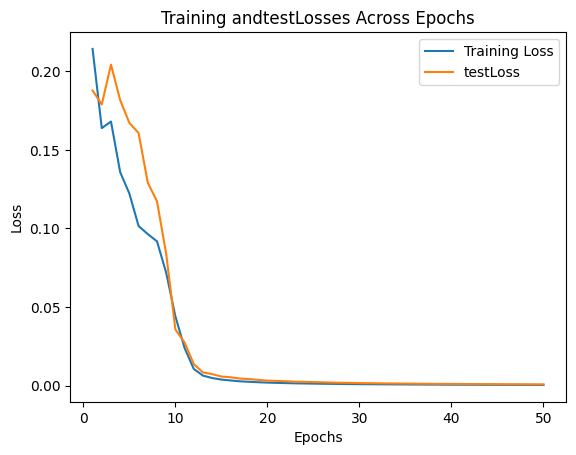

In [230]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params)  

accuracy on test set 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



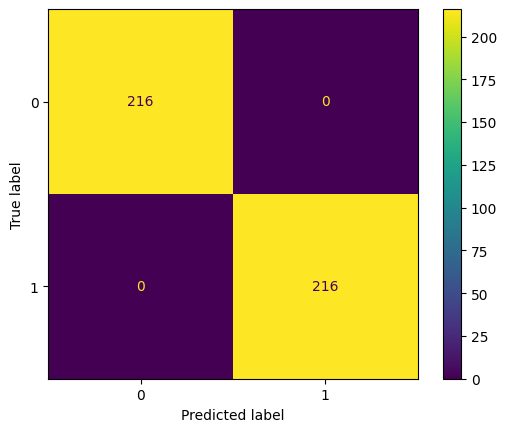

------------------------------------------------------------------------------------------------------


In [231]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")


MONK 2

In [232]:
input_size = 17  
output_size = 1
params_grid_general = {
    "hidden_size": [3, 4, 5],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0,0.001,0.01],
    "momentum": [0],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
    "l1_lambda":[0]

}


params_grid = {
    "hidden_size": [4],
    "learning_rate": [0.8],
    "batch_size": [4],
    "weight_decay": [0],
    "momentum": [0.5],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
    "l1_lambda":[0]

}
    

dataset_train_part = read_ds(TR_PATH_2)
dataset_test_part = read_ds(TS_PATH_2)

dataset = dataset_train_part

best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size)
        




Actual iter 0.0%
Early stopping: 41
Early stopping: 41
Early stopping: 37
Early stopping: 46
Early stopping: 42


In [233]:
#Best parameters found
print(f"Best hidden size: {best_params[4]} \nBest learning rate: {best_params[1]} \nBest batch size: {best_params[8]} \nBest weight decay: {best_params[7]} \nBest momentum: {best_params[5]}")

print(best_params)

Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.009360009054827659, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)


Starting epoch 1
0.22968808706435892
Starting epoch 2
0.23187179468503152
Starting epoch 3
0.21163225518884482
Starting epoch 4
0.2054561836541527
Starting epoch 5
0.16049307764128404
Starting epoch 6
0.13863140508894706
Starting epoch 7
0.055047111592203796
Starting epoch 8
0.020810228285241733
Starting epoch 9
0.01026946801963883
Starting epoch 10
0.005967732874624845
Starting epoch 11
0.005272162854520569
Starting epoch 12
0.0036478261862174367
Starting epoch 13
0.003209255009467058
Starting epoch 14
0.002738975208086669
Starting epoch 15
0.002288040125643386
Starting epoch 16
0.002037511991888837
Starting epoch 17
0.0018531542400187053
Starting epoch 18
0.0016669073296792772
Starting epoch 19
0.0015231516202523683
Starting epoch 20
0.0013831548273662553
Starting epoch 21
0.0012766553799910642
Starting epoch 22
0.0011997777333750423
Starting epoch 23
0.001113627262249658
Starting epoch 24
0.0010467662890463274
Starting epoch 25
0.0009842305019750104
Starting epoch 26
0.0009273722148

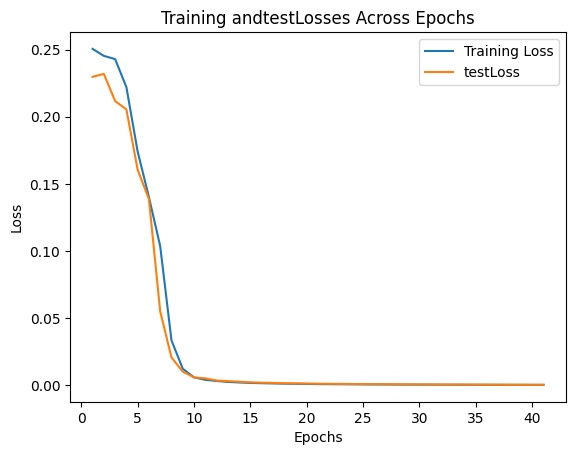

In [234]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params)  

accuracy on test set 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



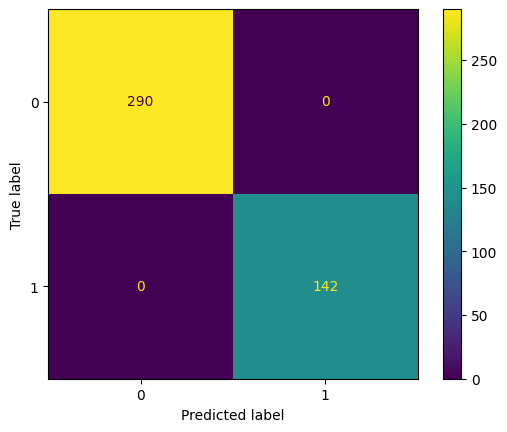

------------------------------------------------------------------------------------------------------


In [235]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")


MONK 3

In [236]:
input_size = 17  
output_size = 1
params_grid = {
    "hidden_size": [3, 4, 5, 10],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0.6,0.8,0.9],
    "momentum": [0,0.1,0.4,0.7,0.8],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
    "l1_lambda":[0.1,0.2,0]

}


params_grid_sp = {
    "hidden_size": [4],
    "learning_rate": [0.8],
    "batch_size": [4],
    "weight_decay": [0.9],
    "momentum": [0.5],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
    "l1_lambda":[0.5]
}
    

dataset_train_part = read_ds(TR_PATH_3)
dataset_test_part = read_ds(TS_PATH_3)

dataset = dataset_train_part

best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size)
        




Actual iter 0.0%
Early stopping: 35
Early stopping: 20
Early stopping: 23
Early stopping: 31
Early stopping: 31


In [237]:
#Best parameters found
print(f"Best hidden size: {best_params[4]} \nBest learning rate: {best_params[1]} \nBest batch size: {best_params[8]} \nBest weight decay: {best_params[7]} \nBest momentum: {best_params[5]}")

print(best_params)

Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0.9 
Best momentum: 0.5
(0.25576952294508615, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0.9, 4)


Starting epoch 1
0.2510296655473886
Starting epoch 2
0.250541847475149
Starting epoch 3
0.25437779172703073
Starting epoch 4
0.24951218565305075
Starting epoch 5
0.2592880476128172
Starting epoch 6
0.25060028306863924
Starting epoch 7
0.24937184982829624
Starting epoch 8
0.24944942527347141
Starting epoch 9
0.2494748934275574
Starting epoch 10
0.25089921457348047
Starting epoch 11
0.24924674961302015
Starting epoch 12
0.25071264527462145
Starting epoch 13
0.2553284186179991
Starting epoch 14
0.2554182461290448
Starting epoch 15
0.24922861986690098
Starting epoch 16
0.25091401846320543
Starting epoch 17
0.24929536713494194
Starting epoch 18
0.24989088031428833
Starting epoch 19
0.2565345873159391
Starting epoch 20
0.24925008085038927
Starting epoch 21
0.24967172741889954
Starting epoch 22
0.24939579102728102
Starting epoch 23
0.25469046155059777
Starting epoch 24
0.2508209470521521
Starting epoch 25
0.25666466024186874
Starting epoch 26
0.2521001994609833
Starting epoch 27
0.25612059511

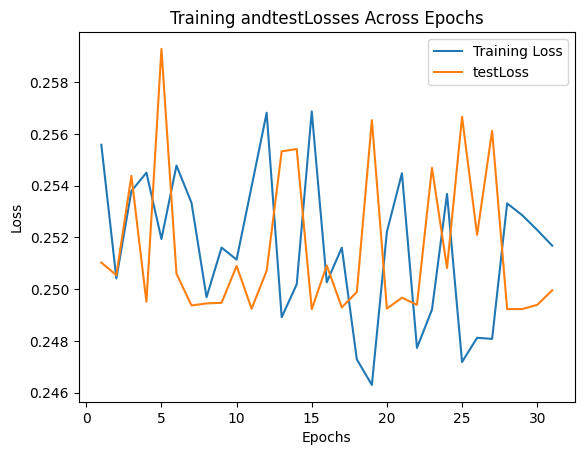

In [238]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params)  

accuracy on test set 0.528
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       204
           1       0.53      1.00      0.69       228

    accuracy                           0.53       432
   macro avg       0.26      0.50      0.35       432
weighted avg       0.28      0.53      0.36       432



c:\Users\given\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\given\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\given\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

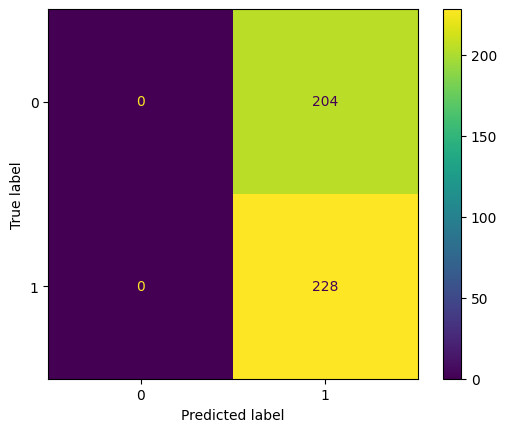

------------------------------------------------------------------------------------------------------


In [239]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")
